# Finding the Displacement
 
 This code is used to get the displacment of the vertexes of specific images.

In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread
from pathlib import Path
import os
from Modules import specificOutline, getFileDir, getOutlines, smoother, splitImg, plotSide # Custom module for readability
import Modules_Displacement # custom module for readability
import Modules
from PIL import Image

Now, we need a list with all the .npy files, that way we can manipulate the outlines as we wish 

In [3]:
# List of Files
# Importing all the files
# If the folder containing the .npy and png (or .tif files) are stored 
npyDir = "SingleCellAblation"
basedir = os.path.join(Path.cwd(), npyDir)

files = io.get_image_files(basedir, "")

# Makes the directy to point to the seg files
dir = []
for f in files: 
    dir.append((os.path.join(basedir, f) + "_seg.npy").replace(".png", ""))
dir = dir

As the machine learning process will mis-label certain ROIs, we need to find a way to obtain the correct ROI. We can't just say "pick the 13th ROI for each image" because the 13th ROI may refer to different cells in each image. In order to fix this, we can approximate the common coordinates of the ROI we want, and store whatever ROI that is in a list named "roi\_name" 

In [4]:

roi_name = [] # a list containing the name of the roi we need

for i in range(len(dir)):  
    dat = np.load(dir[i], allow_pickle=True).item()
    masks = dat['masks'] # Using the masks gives us a larger target to select from than outlines
    filenam = dat['filename']
# box = (25, 40, 125, 120)
    width, height = masks.shape
    neededROI = masks[width//2][height//2] # the general area of where our ROI will always be

    # the below code saves the outline in an image file

    if neededROI != 0: 
        roi_name.append([i, neededROI])
        newmas = specificOutline(masks, neededROI)
        filedir = (os.path.join(Path.cwd(), "SCA_images" ))
        nam = str(i) + '.png'
        # plt.gca().set_axis_off()
        # plt.imsave(os.path.join(filedir, nam), newmas ,cmap = 'gray')


(5, 23, 5, 22)


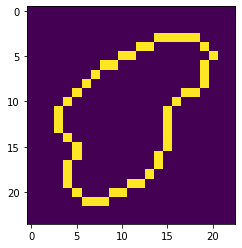

In [5]:
filenum = 4 # The file, or frame of the image you wish to open

a, b = roi_name[filenum]
datFirst = np.load(dir[a], allow_pickle=True).item()
arr = datFirst['outlines']
darr = datFirst['masks']
r = specificOutline(arr, b) # image of the outline
dr = specificOutline(darr, b) # image of the mask

plt.imshow(r)
q, v, w, j = Modules.GetPositions(r)
print(Modules.GetPositions(r))
plt.imshow(Modules.Shrink(r, 3, q, v, w, j, manual=True))


In [6]:
filenum = 4 # The file, or frame of the image you wish to open

a, b = roi_name[filenum]
datFirst = np.load(dir[a], allow_pickle=True).item()
arr = datFirst['outlines']
darr = datFirst['masks']
r = specificOutline(arr, b) # image of the outline
dr = specificOutline(darr, b) # image of the mask
q, v, w, j = Modules.GetPositions(r)

# The below code will now create a list of the rois

outlineList = []
maskList = []

for i in range(len(roi_name)): 
    a, b = roi_name[i]
    datFirst = np.load(dir[a], allow_pickle=True).item()
    arr = datFirst['outlines']
    darr = datFirst['masks']
    # Modules.Shrink(specificOutline(arr, b), 5, q, v, w, j, manual=True)
    # outlineList.append(Modules.Shrink(specificOutline(arr, b), 3, q, v, w, j, manual=True))
    # maskList.append(Modules.Shrink(specificOutline(darr, b), 3, q, v, w, j, manual=True))
    #Trying without shrinking
    outlineList.append(specificOutline(arr, b))
    maskList.append(specificOutline(darr, b))

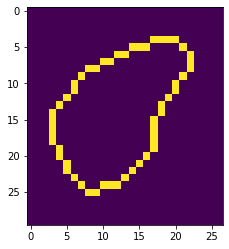

In [7]:
plt.imshow(outlineList[3])


# Getting the vertexes | Using pixel manipulation
We have several methods of getting the edges. The most basic way is to detect the top, bottom, left and right most pixels in each frame and compare them


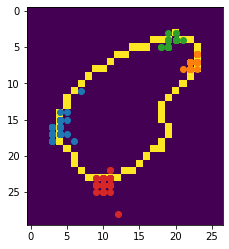

In [8]:

a = []

for i in range(len(outlineList)):
    outl = outlineList[i]
    a.append(Modules_Displacement.selfGetEdges(outl))

# outl = outlineList[26]
# a.append(Modules_Displacement.selfGetEdges(outl))

a = np.asarray(a)
L1 = L2 = R1= R2= T1= T2= B1= B2 = np.zeros(len(a))

L1 = a[:, 0]
L2 = a[:, 1]
R1 = a[:, 2]
R2 = a[:, 3]
T1 = a[:, 4]
T2 = a[:, 5]
B1 = a[:, 6]
B2 = a[:, 7]

plt.scatter(L1, L2)
plt.scatter(R1, R2)
plt.scatter(T2, T1)
plt.scatter(B1, B2)

plt.imshow(outl)


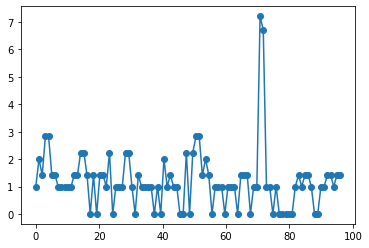

In [10]:
dis = Modules_Displacement.GetDisplacement(L1, L2)
x = np.linspace(0, len(dis), len(dis))
plt.plot(x, dis)
plt.scatter(x, dis)

# The Results aren't what we expect, however, whether this is because of the cell segmentation or because of the 
# Vertex Detection remains to be seen 

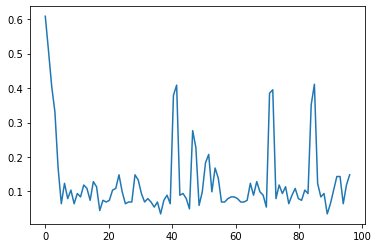

In [10]:
dis2 = Modules_Displacement.GetMSE(maskList)
plt.plot(x, dis2)

# By using the MSE on the images we have obtained, we can see that there are peaks where we expect them to be, 
# but also alot of noise that we do not want. This means maybe a higher resolution image, with better cell 
# segmentation can be useful

However, we Can try other methods as well. Such as Contour detection

# Contour Detection
this by far seems to be the most promising method of detetecting the cell edges

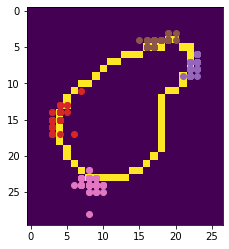

In [11]:
v = 45
a = []
for i in range(len(maskList)): 
    r = maskList[i]
    plt.imshow(r)
    a.append(Modules_Displacement.getEdges(r))

a = np.asarray(a)
# The following lists will have the coordinates for the left, right, top and bottom coordinates of the specified cell 

L1 = a[:, 0]
L2 = a[:, 1]
R1 = a[:, 2]
R2 = a[:, 3]
T1 = a[:, 4]
T2 = a[:, 5]
B1 = a[:, 6]
B2 = a[:, 7]


plt.imshow(outlineList[v])
plt.scatter(L1[v], L2[v])
plt.scatter(R1[v], R2[v])
# plt.scatter(T2[v], T1[v])
plt.scatter(B1[v], B2[v])

plt.scatter(L1, L2)
plt.scatter(R1, R2)
plt.scatter(T1, T2)
plt.scatter(B1, B2)

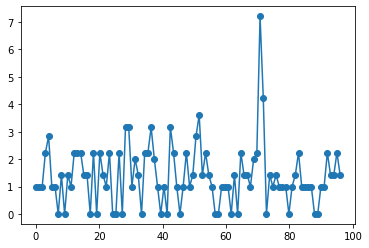

In [12]:
dis = Modules_Displacement.GetDisplacement(L1, L2)
x = np.linspace(0, len(dis), len(dis))
plt.plot(x, dis)
plt.scatter(x, dis)

# The results are very similar to what we got before. 

In [1]:
ndis = []
for i in range(dis): 
    ndis[i + 1] = ndis[i] + dis[i]



NameError: name 'dis' is not defined

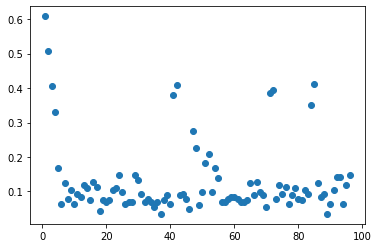

In [13]:
dis = Modules_Displacement.GetMSE(maskList)
x = np.linspace(1, len(dis), len(dis))
plt.scatter(x, dis)

This is better, however, it would be preferable if we could detect MORE vertex points, such as the ones at the bottom and the sides. However, this method has produced the most consistent results so far. However, whether it can rival someone doing in manually through imageJ remains to be seen. These images can be put into image J which will make the correcting process significanly easier though. 

One way to go about this is to try and half the image so that it turns into two curves which are not enclosed. Now, we can find the peaks and troughs of these values based on the slope of a specific part 

# Splitting and using algorithms

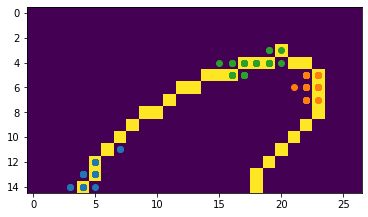

[[ 4 14 22  6 17  4  4 14]
 [ 4 13 23  5 15  4  4 14]
 [ 4 14 23  6 19  3  4 14]
 [ 3 14 22  6 17  4  3 14]
 [ 5 13 22  7 16  5  5 14]
 [ 4 14 22  7 17  5  4 14]
 [ 5 13 21  6 17  5  5 14]
 [ 4 14 22  6 17  5  4 14]
 [ 4 13 22  7 17  5  4 14]
 [ 4 14 22  7 17  5  4 14]
 [ 4 14 22  7 17  5  4 14]
 [ 4 14 22  7 16  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 14 22  7 17  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 14 22  6 17  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 13 22  6 16  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 14 23  6 16  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 14 22  6 19  4  4 14]
 [ 4 14 22  6 19  4  4 14]
 [ 4 14 22  7 16  5  4 14]
 [ 4 13 23  6 20  4  4 14]
 [ 4 14 22  6 16  5  4 14]
 [ 4 13 22  6 19  4  4 14]
 [ 4 13 22  6 18  4  4 14]
 [ 4 14 22  6 19  4  4 14]
 [ 4 14 22  6 19  4  4 14]
 [ 4 14 22  6 19  4  4 14]
 [ 4 14 22  6 18  4  4 14]
 

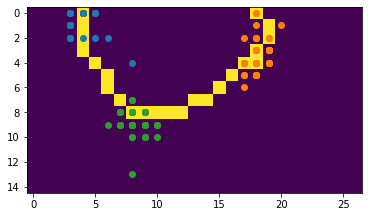

In [14]:
# This code will get me the rows I need
# This part of the code will get me the top, the mid, the right and the bottom parts of the figure. 
# With this we can crop the matrix for only the useful data
points = []
a1 = []
a2 = []
for i in range(len(maskList)): 
    r = outlineList[i]
    m1, m2 = Modules.splitImg(r) # this split's the ith image

    a1.append(Modules_Displacement.getEdges(m1)) # This module uses the contours
    a2.append(Modules_Displacement.getEdges(m2)) # This module uses the contours
   

a1 = np.asarray(a1)
a2 = np.asarray(a2)


fL1 = a1[:, 0]
fL2 = a1[:, 1]
fR1 = a1[:, 2]
fR2 = a1[:, 3]
fT1 = a1[:, 4]
fT2 = a1[:, 5]
# fB1 = a1[:, 6]
# fB2 = a1[:, 7]

plt.scatter(fL1, fL2)
plt.scatter(fR1, fR2)
plt.scatter(fT1, fT2)
# plt.scatter(fB1, fB2)
plt.imshow(m1)
plt.show()

sL1 = a2[:, 0]
sL2 = a2[:, 1]
sR1 = a2[:, 2]
sR2 = a2[:, 3]
sT1 = a2[:, 4]
sT2 = a2[:, 5]
sB1 = a2[:, 6]
sB2 = a2[:, 7]

plt.scatter(sL1, sL2)
plt.scatter(sR1, sR2)
# plt.scatter(sT1, sT2)
plt.scatter(sB1, sB2)
plt.imshow(m2)

print(a1)

From this, we can see we have now gotten 6 vertex points. 

# Turning to equations
### Everything below this point is extremely experimental and may be ignored 
These look like graphs. Perhaps we could consider these to be individal points and use interpolation to create a curve

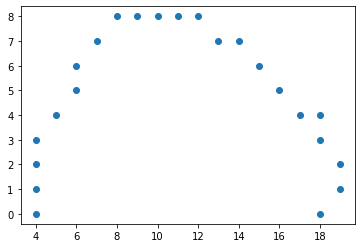

In [15]:

X2 = []
Y2 = []

a, b = m2.shape

for p in range(b): 
    for q in range(a): 
        if m2[q][p] != 0: 
           X2.append(p)
           Y2.append(q)
                

X2 = np.asarray(X2)
Y2 = np.asarray(Y2)
plt.scatter(X2, Y2)


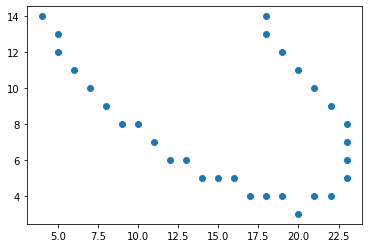

In [16]:
X1 = []
Y1 = []

c, d = m1.shape
for y in range(c): 
    for x in range(d):
        if m1[y][x] != 0: 
            X1.append(x)
            Y1.append(y)
                

X1 = np.asarray(X1)
Y1 = np.asarray(Y1)

plt.scatter(X1, Y1)

In [17]:

# # small = 0
# # big = 0 
# # i = 0
# # def looper(X2, Y2): 
# #     b = 0 
# #     s = 0
# #     ns = 0 
# #     i = 0

# #     while Y2[i] <= Y2[i + 1] : 
# #         if Y2[i] < Y2[s]: 
# #             s = i
# #             i +=1 
# #     b = i 
# #     # big.append(b)
# #     # small.append(s)
  
# #     while Y2[i] >= Y2[i + 1] and i != len(Y2) - 2: 
# #         i += 1
# #     ns = i

# #     if Y2[-1] == Y2[ns]: 
# #         X2 = []
# #         Y2 = []
# #     else: 
# #         print(ns)
# #         nX2 = X2[ns::]
# #         nY2 = Y2[ns::]
#     # nextsmal.append(ns)
#     # plt.scatter(X2, Y2)
#     # plt.scatter(X2[small], Y2[small])
#     # plt.scatter(X2[big], Y2[big])
#     # plt.scatter(X2[nextsmal], Y2[nextsmal])
 
#     # if len(nX2 > 5): 
#     #     print("one")
#     #     # looper(nY2, nX2, small, big, nextsmal)
#     # else: 
#     # return small, big, nextsmal
#     return s, b, ns, nX2, nY2

# nX2 = X2
# nY2 = Y2 
# count = 0 
# # while len(nY2) > 3 and count < 10: 
# a, b, c, nX2, nY2 =looper(nX2, nY2)
# plt.scatter(nX2, nY2)
# plt.scatter(nX2[a], nY2[a])
# plt.scatter(nX2[b], nY2[b])
# plt.scatter(nX2[c], nY2[c])
# count += 1 
# print(c)

In [18]:
# ns = 27

# nX2 = X2[ns::]
# nY2 = Y2[ns::]

# plt.scatter(nX2, nY2)

# a, b, c = looper(nX2, nY2)
# print(b)
# plt.scatter(nX2[a], nY2[a])
# plt.scatter(nX2[b[1]], nY2[b[1]])

In [19]:
from operator import invert
from scipy.signal import argrelmax, argrelextrema
# smoothy = smoother(np.asarray(Y), 51)
# smoothx = smoother(np.asarray(X), 21)

# dy = smoother(Y1)

# plt.scatter(X1, dy )

maxs = argrelextrema(Y1, np.greater)
mins = argrelextrema(Y1, np.less)

print(maxs)
# # plt.scatter(smoothx, smoothy)
# plt.scatter(X1, Y1)
# plt.ylim(max(Y1), min(Y1))
# a = maxs[0]
# Xn = []
# Yn = []
# print(a)
# for g in a:
#     if g < len(X1):  
#         Xn.append(X1[g]) 
#         Yn.append(Y1[g])
# plt.scatter(Xn, Yn, color = "red")

# # plt.scatter(Xn, Yn, color = "red")

# # plt.scatter(X[a[1]], Y[a[1]], color = "red")
# # plt.scatter(X[a[2]], Y[a[2]], color = "red")
# # res1 = np.where(dy == max(dy))[0][0]
# # res2 = np.where(dy == min(dy))[0][0]

(array([], dtype=int64),)


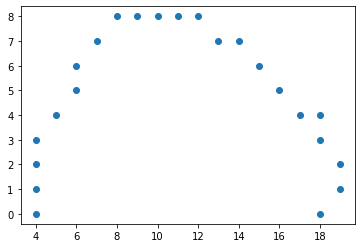

In [20]:
# Let's try using derivatives 
# First task, find the position of every pixel 

X1 = X2 = []
Y1 = Y2 =[]

a, b = m2.shape

for p in range(b): 
    for q in range(a): 
        if m2[q][p] != 0: 
            X2.append(p)
            Y2.append(q)
plt.scatter(X2, Y2)
# plt.plot(X2, Y2)
# plt.ylim(max(Y2) + 5, min(Y2))

Now we can use an algorithm as follows, we keep moving until we find the next lowest point

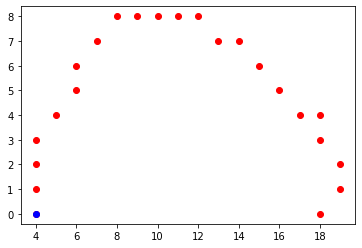

In [21]:
plt.scatter(X2, Y2, color = "red")
plt.scatter(X2[0], Y2[0], color = "blue")


# Using a Filter

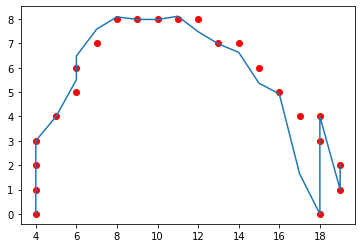

In [22]:
from scipy import signal
yhat = signal.savgol_filter(Y2, 10, 9) # window size 51, polynomial order 11

X2 = np.asarray(X2)
Y2 = np.asarray(Y2)

plt.plot(X2, yhat)
plt.scatter(X2, Y2, color = "red")

(array([ 8, 11, 20], dtype=int64), {'peak_heights': array([8.08123779, 8.11019897, 4.        ]), 'left_thresholds': array([0.49946594, 0.13458252, 1.        ]), 'right_thresholds': array([0.09944153, 0.63404846, 3.        ])})
[ 8 11]


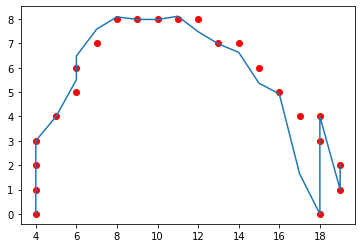

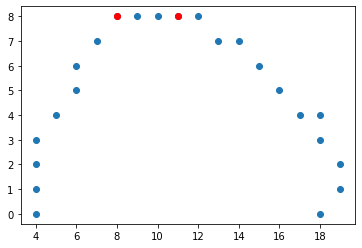

In [23]:
yhat1 = signal.savgol_filter(Y1, 10, 9) # window size 51, polynomial order 11

X1 = np.asarray(X1)
Y1 = np.asarray(Y1)

plt.plot(X1, yhat1)
plt.scatter(X1, Y1, color = "red")

peaks = signal.find_peaks(yhat1, height = 1,  threshold= 0, distance = 1)
print(peaks)
height = peaks[1]['peak_heights']
peak_pos = X1[peaks[0]]

print(peak_pos[0:-1])
peak_pos= peak_pos[0:-1]
fig = plt.figure()

ax = fig.subplots()
ax.scatter(X1, Y1)
ax.scatter(peak_pos, Y1[peak_pos], color = "r")

(array([ 8, 11, 20], dtype=int64), {'peak_heights': array([8.08123779, 8.11019897, 4.        ]), 'left_thresholds': array([0.49946594, 0.13458252, 1.        ]), 'right_thresholds': array([0.09944153, 0.63404846, 3.        ])})
[ 8 11]


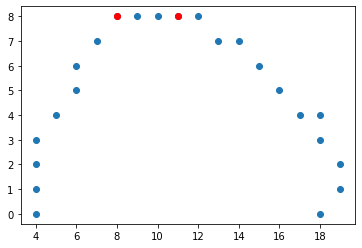

In [24]:
peaks = signal.find_peaks(yhat, height = 1,  threshold= 0, distance = 1)
print(peaks)
height = peaks[1]['peak_heights']
peak_pos = X2[peaks[0]]

print(peak_pos[0:-1])
peak_pos= peak_pos[0:-1]
fig = plt.figure()

ax = fig.subplots()
ax.scatter(X2, Y2)
ax.scatter(peak_pos, Y2[peak_pos], color = "r")

While this does work, the function should be smooth. In order for us to get a correct value, we can manipulate our data such that if for a given Y value, there are several X values, only consider the one which is in the middle. 

(array([20], dtype=int64), {'peak_heights': array([4.]), 'left_thresholds': array([1.]), 'right_thresholds': array([3.])})


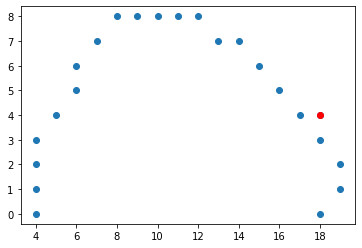

In [25]:
from scipy import signal
peaks = signal.find_peaks(Y1, height = 1, threshold = 1, distance = 1)
print(peaks)
height = peaks[1]['peak_heights']
peak_pos = X1[peaks[0]]

fig = plt.figure()
ax = fig.subplots()
ax.scatter(X1, Y1)
ax.scatter(peak_pos, height, color = "r")

In [26]:
from scipy import signal
sig = Y2
sig_peaks, _ = signal.find_peaks(Y2)
promin = signal.peak_prominences(sig, sig_peaks)[0]
promin

array([8., 3.])

In [27]:
# def FindDistance(A, B, start, index): 
#     return np.sqrt(A[start]**2 + B[index]**2)

# # def CountUp(starin, x, y): # two arrays
# #     while starin != len(x): 
        
# t, b, r, l = GetPositions(m2)
# find_x(b, X2, Y2)
# # starin = Y2.index(t)
# # startpos = [X2[starin], t]
# # if starin == 0:
    
# #     # continue 
# # elif starin > 0: 
# #     #check till  zero and then back 

# # plt.scatter(X2[Y2.index(t)], t)

# Using Derivatives

[13 18]


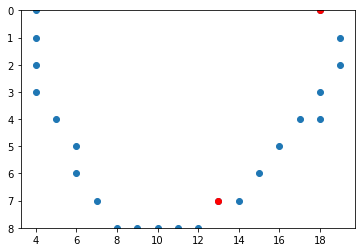

In [28]:
from operator import invert
from scipy.signal import argrelmax, argrelextrema
# smoothy = smoother(np.asarray(Y), 51)
# smoothx = smoother(np.asarray(X), 21)
y1 = np.asarray(Y1)
y2 = np.asarray(X2)
dy = np.diff(y1)
dy = smoother(dy, 1)
maxs = argrelextrema(dy, np.greater)
# mins = argrelextrema(Y, np.less)
# plt.scatter(smoothx, smoothy)
plt.scatter(X1, Y1)
plt.ylim(max(Y1), min(Y1))
a = maxs[0]
Xn = []
Yn = []
print(a)
for g in a:
    if g < len(X1):  
        Xn.append(X1[g]) 
        Yn.append(Y1[g])
plt.scatter(Xn, Yn, color = "red")

# plt.scatter(Xn, Yn, color = "red")

# plt.scatter(X[a[1]], Y[a[1]], color = "red")
# plt.scatter(X[a[2]], Y[a[2]], color = "red")
# res1 = np.where(dy == max(dy))[0][0]
# res2 = np.where(dy == min(dy))[0][0]

In [29]:
# An attempt to get the maximum value 

# def getMax(arr, le): 
#      found = False
#      pos = 0 
#      npos = 0
#      m = 0 
#      nm = 0
     
#      while found == False: 
#           npos = pos + le
#           m = max(arr[pos:npos])
#           pos = np.where(arr[pos:npos] == m)[0
#           nm = max(arr[npos:npos + le])
#           if nm == m: 
#                found = True
#      print(pos, m)


# getMax(np.asarray(Y1), 2)

# Using Interpolation

In [30]:
def checker(ynew):
    g = 1
    Done = False
    con = True
    max = []
    for i in range(1, len(ynew)):  # go through the graph
        con = True                 # flag on to continue or not
        print(i)
        while g != 5 or con == True:   # tells you whether to continue or not
            if i - g < 0 or i + g > len(ynew):
                con = False
                print("reached an end")
            if ynew[i - g] < ynew[i] and ynew[i + g] > ynew[i] and con == True: # check if the gth point behind the current point 
              
                if  g < 5: 
                    g += 1 
                if  g >=5: 
                    max.append(i)
            else: 
                con = False
    return max

# m = checker(Y2)
# This funciton checks to see if we have reached the end of an array

In [31]:
# plt.scatter(X, Y)
# plt.scatter(X[res1], Y[res1], color = "red")
# plt.scatter(X[res2], Y[res2], color = "red")

In [8]:
import numpy

villagers = 1000 # number of villagerss
sad = 1000
happy = 0
neutral = 0 


def sadtohapp(a): 
    return numpy.ceil(a*0.02) # give num of attentives that get bored

def happtosad(a): 
    return numpy.ceil(a*0.3) # give num of attentives that get bored

def happtoneutral(b): 
    return numpy.ceil(b* 0.2) # gives num of bored that become attentive

def neutraltohapp(a): 
    return numpy.ceil(a*0.4) # give num of attentives that get bored

def neutraltosad(c): 
    return numpy.ceil(c * 0.02)

def sadtoneutral(c): 
    return numpy.ceil(c * 0.05)

print(0.2 + 0.3 + 0.2 + 0.4 + 0.02 + 0.05)

sad0 = 0.4 * 1000
happy0 = 0.5 * 1000 
neutral0 = 0.1  * 1000

for i in range(5): 
    sad = sad0
    neutral = neutral0
    happy = happy0

    sad0 = sad + happtosad(happy) + neutraltosad(neutral) - sadtohapp(sad) - sadtoneutral(sad)
    neutral0 = neutral0 + happtoneutral(happy) + sadtoneutral(sad) - neutraltohapp(neutral) - neutraltosad(neutral)
    happy0 = happy0 + neutraltohapp(neutral) + sadtohapp(neutral) - happtoneutral(happy) - happtosad(happy) 

    print(sad0 + happy0 + neutral0)

print(sad0, neutral0, happy0)

1.1700000000000002
994.0
987.0
979.0
970.0
961.0
636.0 167.0 158.0
